In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [2]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint  # This library is nothing but print the messages in better way.
messages = [AIMessage(content=f"Please tell me how can I help",name="Assistant")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Pawan"))
messages.append(AIMessage(content=f"Which programming Language you want to learn ?",name="Assistant"))
messages.append(HumanMessage(content=f"Hey i want to learn Python with LLM model development, explain me in 10 bullet points and make sure gap is proper between them",name="Pawan"))

for mesage in messages:
    mesage.pretty_print()


================================== Ai Message ==================================
Name: Assistant

Please tell me how can I help
================================ Human Message =================================
Name: Pawan

I want to learn coding
================================== Ai Message ==================================
Name: Assistant

Which programming Language you want to learn ?
================================ Human Message =================================
Name: Pawan

Hey i want to learn Python with LLM model development, explain me in 10 bullet points and make sure gap is proper between them


In [3]:
# When Chat model called this is how AIMessage model will call and messag is extracted from the model given below.
from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen/qwen3-32b")
result = llm.invoke(messages)


In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 751,
  'prompt_tokens': 76,
  'total_tokens': 827,
  'completion_time': 2.293872962,
  'prompt_time': 0.003732262,
  'queue_time': 0.049943968,
  'total_time': 2.297605224},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

In [7]:
def add(a:int , b:int)->int:
    # Here defining everything in docstring as this help LLM to understand what to do in this.
    """
    Add a and b

    a(int): first int
    b(int): second int

    return:
        int
    """
    return a+b

In [8]:
def mul(a:int , b:int)->int:
    # Here defining everything in docstring as this help LLM to understand what to do in this.
    """
    Add a and b

    a(int): first int
    b(int): second int

    return:
        int
    """
    return a*b

In [11]:
## Binding tool with LLM
llm_with_tools=llm.bind_tools([add,mul])
tool_call=llm_with_tools.invoke([HumanMessage(content=f"Hey what answer for 2 multiply by 3 ?",name="Pawan")])


In [12]:
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking for 2 multiplied by 3. Let me check the available tools. There's a function called 'mul' which takes two integers a and b and returns their product. So I need to call the 'mul' function with a=2 and b=3. That should give the correct result. I'll structure the tool call accordingly.\n", 'tool_calls': [{'id': 'qm3h7cd26', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'mul'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 263, 'total_tokens': 367, 'completion_time': 0.15910717, 'prompt_time': 0.012176193, 'queue_time': 0.066910627, 'total_time': 0.171283363}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a3d1d56-f57e-4500-acf1-9531f411daf3-0', tool_calls=[{'name': 'mul', 'args': {'a': 2, 'b': 3}, 'id': 'qm3h7cd26', 'type': 'tool_cal

In [14]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages  # Reducer , it will merge messages and will not allow override messages , allow only append.
from typing import Annotated
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

In [15]:
# THis is message feed to LLM model
initial_messages = [AIMessage(content=f"Please tell me how may i help you ", name="Assistant")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Pawan"))
initial_messages

[AIMessage(content='Please tell me how may i help you ', additional_kwargs={}, response_metadata={}, name='Assistant'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Pawan')]

In [16]:
# This is another set of AI message now will feed this to LLM model , by appending this to initial_meassge also this will not override previous message
ai_message=AIMessage(content=f"Which programming language you want to learn",name="Assistant")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='Assistant')

In [17]:
# Here i added initial_messages with ai_message and here we can see initial and AI message is combined together
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how may i help you ', additional_kwargs={}, response_metadata={}, name='Assistant', id='5f2d247f-82d1-4207-9bd6-b1619e7bf838'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Pawan', id='815873b6-4ad4-45e6-9e68-822641380aac'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='Assistant', id='188df5a0-840b-4d5e-bd73-fb58a12c8af3')]

In [18]:
# Chatbot node functionality 
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [19]:
from IPython.display import Image , display
from langgraph.graph import StateGraph , START,END
builder = StateGraph(State)

builder.add_node("llm_tool",llm_tool)
builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

In [20]:
graph = builder.compile()

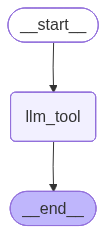

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
tools = [add ,mul]


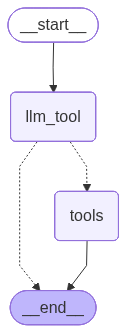

In [27]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

## Add the nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
# Add Edges

builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> Tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition outes to END
    tools_condition
)

builder.add_edge("tools",END)

graph_builder = builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [31]:
# Invocation

messages = graph_builder.invoke({"messages":"What is multiplication of 10 and 3"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is multiplication of 10 and 3
================================== Ai Message ==================================
Tool Calls:
  mul (gqddctwzr)
 Call ID: gqddctwzr
  Args:
    a: 10
    b: 3
================================= Tool Message =================================
Name: mul

30


In [32]:
# Invocation without tool_message

messages = graph_builder.invoke({"messages":"What is machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

The functions provided (add and multiply) are not applicable for defining machine learning. Here's an explanation:

**Machine learning** is a subset of artificial intelligence that enables computers to learn patterns and make decisions from data without being explicitly programmed. It involves:
1. **Data input**: Feeding large amounts of relevant data
2. **Pattern recognition**: Identifying patterns in the data
3. **Model training**: Using algorithms to "learn" from the data
4. **Prediction/Decisions**: Applying what's been learned to make predictions or decisions

Common types include supervised learning (with labeled data), unsupervised learning (finding hidden patterns), and reinforcement learning (learning through trial/error with rewards). Examples include spam filters, recommendation systems, a